In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import h5py
import rbm
import rbmg
import rbmg2
from plyer import notification
from scipy.optimize import linear_sum_assignment

## 1. Sampling en tiempos ascendentes: magnetización, susceptibilidad y overlap

In [2]:
timelist = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

In [3]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)

        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
            
        q = []
        q2 = []
        for i in range (N):
            for j in range (i+1,N):
                
                f = torch.mean((2*v[:,i]-1)*(2*v[:,j]-1))
                q.append(f) 
                q2.append(torch.pow(f, 2))
        
            
        chi = (torch.mean(m2)-torch.mean(m)**2).item()
        chi2 = ((np.mean(q2)-np.mean(q)**2)/1000).item()
            
            
        return np.array(m),np.array(chi),np.array(chi2),v #estoy guardando todas las m y la última v

### 1.1. Sampling beta = 1.5  L=1000
(100 cadenas, con 5000 cadenas ninguno baja al m_o=0.07)

In [4]:
tlist = timelist

allt= []
allm = []
allchi = []
allchi2 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    allchi2.append(chi2)

/tmp/ipykernel_3901/1925270158.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


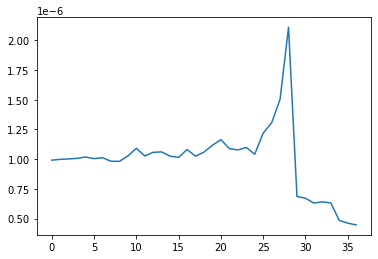

In [5]:
plt.plot(allchi2)

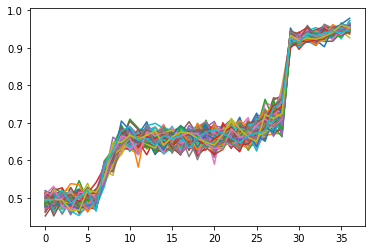

In [6]:
plt.plot(allm);

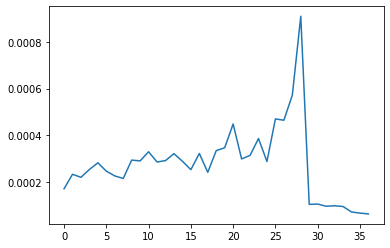

In [7]:
plt.plot(allchi)

### 1.2. Sampling beta=1.5 cadenas de L=100

In [8]:
filename =  'files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'

tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt2 = []
allm2 = []
allchi2 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((100,1000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi2.append(chi)

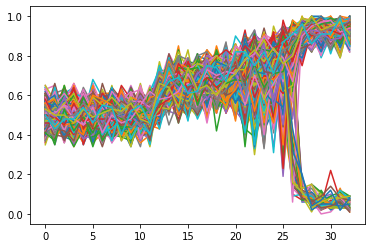

In [10]:
plt.plot(allm2);

## 2. Curie Weiss en RBM binaria

In [11]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def HsamplingB(W,b_h,V):
        
        mh = torch.sigmoid((W.mm(V).t()+b_h).t())
        h = torch.bernoulli(mh)
        return h,mh

def SamplingB(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        

        h,mh = HsamplingB(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)

        for t in range(it-1):
            h,mh = HsamplingB(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)

            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2)).item()
            
            
        return np.array(m),np.array(chi),v #estoy guardando todas las m y la última v

In [12]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

beta 1.5 lr = 1e-4

In [13]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

RBM1p5 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3901/1950621499.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


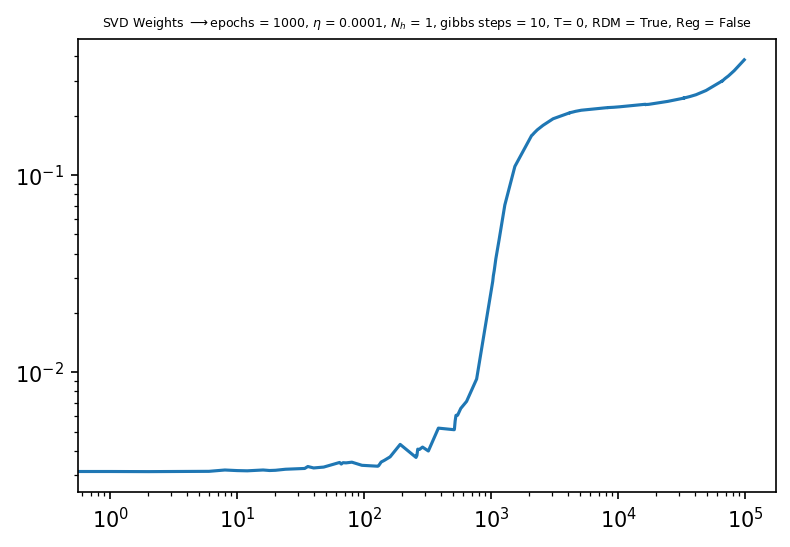

In [14]:
RBM1p5.PlotW()

In [15]:
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

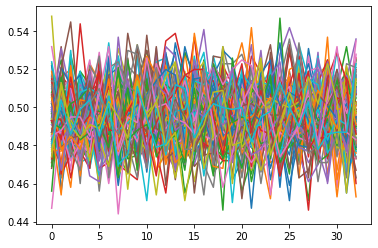

In [29]:
plt.plot(allm3);

beta = 2 lr = 1e-4

In [17]:

filename = "beta2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())            
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


RBM2 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3901/2294994405.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


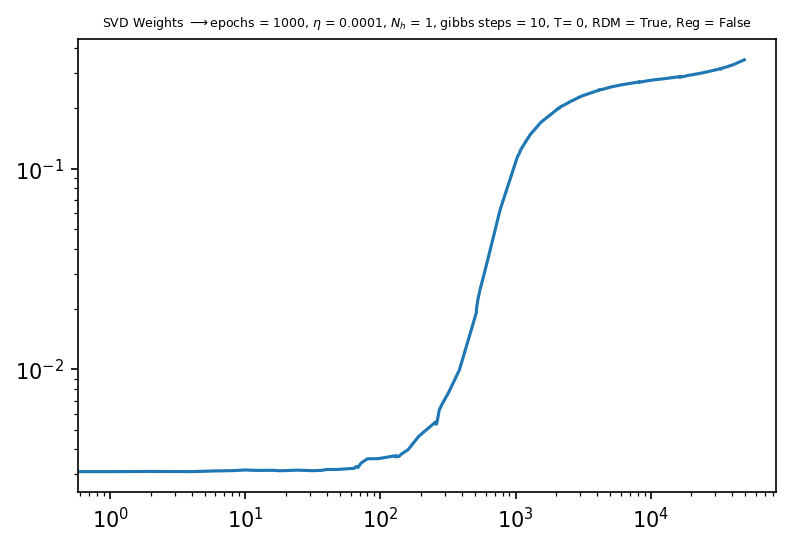

In [18]:
RBM2.PlotW()

In [19]:
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt4 = []
allm4 = []
allchi4 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt4.append(t)
    allm4.append(m)
    allchi4.append(chi)

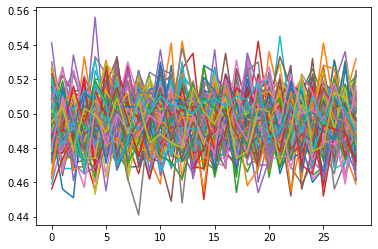

In [30]:
plt.plot(allm4);

beta = 1.5 ñr = 1e-4 regularización

In [21]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())          
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = True
lr = 1e-4
gibbs_steps = 10
epoch_max = 2000
T = 0



filename = 'files/RDMr_CWM_1.5_n1_b100_l1e4_k10_e2k.h5'
f = h5py.File(filename,'r') #w - escribir


RBM1p5r = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3901/2999320407.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


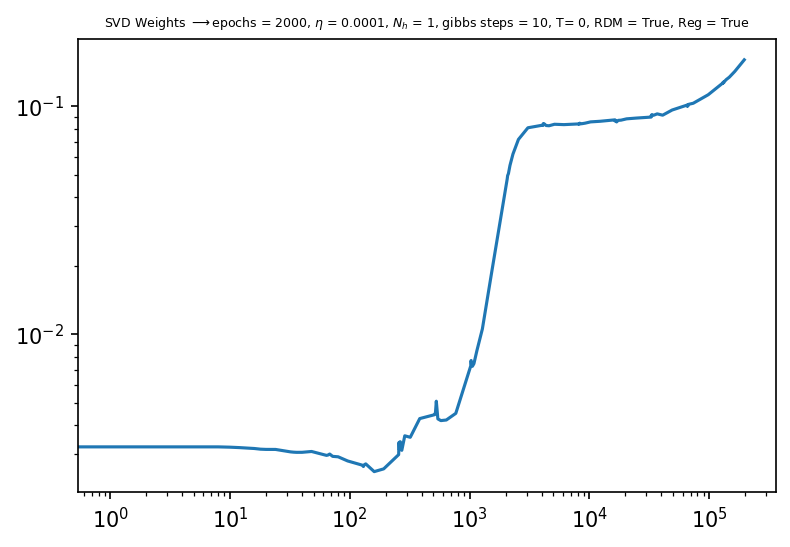

In [22]:
RBM1p5r.PlotW()

In [23]:
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt5 = []
allm5 = []
allchi5 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt5.append(t)
    allm5.append(m)
    allchi5.append(chi)

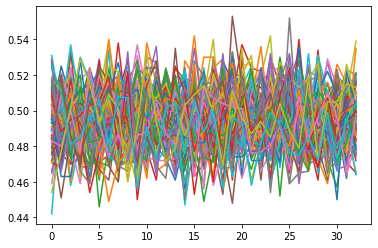

In [31]:
plt.plot(allm5);

beta = 1.5 lr = 1e-2 5k epochs

In [25]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())          
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-2
gibbs_steps = 10
epoch_max = 5000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e2_k10_e5k.h5'
f = h5py.File(filename,'r')


RBM1p5lr = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3901/4118459714.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


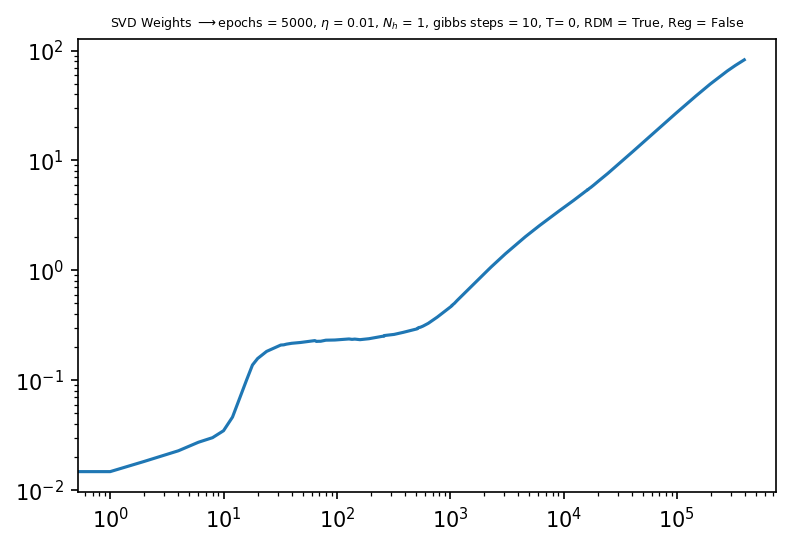

In [26]:
RBM1p5lr.PlotW()

In [27]:
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt6 = []
allm6 = []
allchi6 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt6.append(t)
    allm6.append(m)
    allchi6.append(chi)

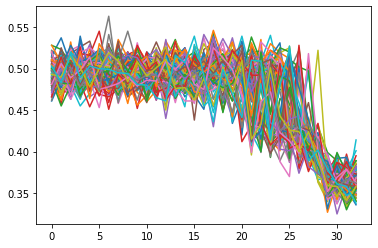

In [32]:
plt.plot(allm6);